# KENDAXA ASSIGNMENT - MACHINE LEARNING POSITION
## Amphibians Classification - *by Jan Kořínek*

### Deliverable goals
#### Classification task

Your goal is to perform exploratory data analysis (EDA)
and to train and compare few models on a classification
task using the dataset Amphibians (https://archive.ics.uci.edu/ml/datasets/Amphibians). Your task is to evaluate the
prediction of the presence of individual amphibians, namely *green frogs, brown frogs, common toad, fire-bellied toad, tree frog,
common newt, and great crested new*. You are not to use the ID
and MV features.

Since your goal is to evaluate and compare several
models along with finding the best one, you have to use
some kind of cross-validation as the dataset is quite small
(which is very common for some of the real world datasets).

If you find it applicable, use statistical tests in the EDA and comparison to distinguish between insignificant differ-
ences and significant ones.

#### Report and scope

You are required to write a brief report in the PDF format
(L A TEXusage is recommend) summarizing the approaches
and presenting the results for all three subtasks. It is rec-
ommend to use figures and plots where it will help you
make your point. The report should contain all the necessary
details to understand what approach you have undertaken,
what were the results and how you interpret them.

our report should summarize the main results of your EDA
but it is sufficient to have the details of the EDA only in the
Jupyter notebook. Briefly (very briefly) introduce the used
models. You should compare the models with regards to
more than one metric each with explanation when is each of
the metrics preferable. You should also state your trust in the
individual models — e.g., that even if some model gives you
very good results, you still might not trust it because it is
sensitive to the data changes. Compare the models also with
respect to their robustness and interpretability. Interpret the
few models you will select as your top ranking candidates,
show which features they are relying the most, etc. Where
applicable, perform formal statistical tests to support your
results.

Please, also state the limitations of your work and direc-
tions, in which it can be expanded — it is expected that you
will not be able to exhaust all possible approaches in the
limited time. Please state which of the possible expansions
are most promising and why.

The report is expected to have about 5–12 pages when using
two-column format with figures but there are no hard limits
as the completeness of the presented information is the
goal (as long as there are no empty sentences or fillers, the
length will not be evaluated).

### Content
1. [Amphibians dataset preparation](#dataset-preparation)

2. [Initial dataset exploration](#dataset-exploration)

    2.1 [Data summary](#data-summary)

    2.2 [Missing values check](#missing-vals)

    2.3 [Data distribution](#data-distribution)

    2.4 [Correlation pairs visualization and pairs sorting](#corr-visu)

3. [Outliers handling](#outliers)

4. [Imbalance dataset handling](#imbalance-handling)

    4.1 [Categorical labels encoding](#encoding)

    4.2 [Multi-label oversampling](#oversampling)

5. [Models training](#models-training)

    5.1 [Training of the multiple models](#training)

    5.2 [Dataset with predicted values finalization](#finalization)

6. [Results discussion](#results-discussion)

7. [Conclusion](#conclusion)

### 1. Amphibians dataset preparation <a name="dataset-preparation"></a>

Dataset in CSV format can be downloaded from the following [link.](https://archive.ics.uci.edu/ml/machine-learning-databases/00528/dataset.csv)

Script `prepare_dataset.py` is responsible for loading raw data into Pandas dataframe, dropping columns *ID* and *Motorway* and save such modified dataframe into *data* folder.

In [1]:
# Load and extract data from raw CSVs into dataframes
%run lib/prepare_dataset.py

# Show processed df
amphibians

Processing raw data...
Dataset processing finished in: 0:00:00


,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,...,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,600,1,1,4,6,2,10,0,0,50,...,0,0,1,0,0,0,0,0,0,0
1,700,1,5,1,10,6,10,3,1,75,...,1,0,1,0,1,1,0,0,1,0
2,200,1,5,1,10,6,10,3,4,75,...,1,0,1,0,1,1,0,0,1,0
3,300,1,5,0,6,10,2,3,4,25,...,0,0,1,0,0,1,0,0,0,0
4,600,2,1,4,10,2,6,0,0,99,...,5,0,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2300,1,12,3,2,2,1,0,0,75,...,1,0,1,0,1,0,0,0,0,0
185,300,1,14,2,7,10,2,0,0,100,...,5,0,1,1,1,1,1,0,1,0
186,500,1,1,4,1,10,2,0,0,100,...,5,0,1,1,1,1,1,0,1,0
187,300,1,12,3,2,1,6,0,0,100,...,0,0,1,0,1,1,0,0,0,0


Dataset itself contains only 189 data points which is very low number. This reflects taking special measures for further processing.

### 2. Initial dataset exploration <a name="dataset-exploration"></a>

In [2]:
# Libraries Import and Fonts setup
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib.misc_functions import print_corr_matrix, remove_outliers, encode_labels,\
    run_ml_sampling, concat_df

# Warnings turn off
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings('ignore')
warnings.warn('ignore')

pd.set_option("display.max.columns", None)
plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rcParams['figure.facecolor'] = 'white'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

#### 2.1 Data summary <a name="data-summary"></a>

In [3]:
# Check the df head
amphibians.head(5)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,600,1,1,4,6,2,10,0,0,50,0,0,0,1,0,0,0,0,0,0,0
1,700,1,5,1,10,6,10,3,1,75,1,1,0,1,0,1,1,0,0,1,0
2,200,1,5,1,10,6,10,3,4,75,1,1,0,1,0,1,1,0,0,1,0
3,300,1,5,0,6,10,2,3,4,25,0,0,0,1,0,0,1,0,0,0,0
4,600,2,1,4,10,2,6,0,0,99,0,5,0,1,0,1,1,1,0,1,1


In [4]:
# Check the df tail
amphibians.tail(5)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
184,2300,1,12,3,2,2,1,0,0,75,2,1,0,1,0,1,0,0,0,0,0
185,300,1,14,2,7,10,2,0,0,100,5,5,0,1,1,1,1,1,0,1,0
186,500,1,1,4,1,10,2,0,0,100,5,5,0,1,1,1,1,1,0,1,0
187,300,1,12,3,2,1,6,0,0,100,1,0,0,1,0,1,1,0,0,0,0
188,300,1,12,3,2,6,10,0,0,100,1,1,0,1,0,1,1,0,0,0,0


In [5]:
# Check sampled data
amphibians.sample(10)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
97,29000,3,1,2,10,6,1,3,3,100,2,0,0,1,1,1,1,1,1,1,1
94,5000,1,1,0,1,10,2,3,2,100,5,5,0,1,1,1,1,1,0,1,0
104,8000,1,1,2,1,10,6,3,2,100,0,2,0,1,1,1,0,0,0,0,0
9,200,1,12,4,2,7,6,0,0,75,1,0,0,1,0,1,1,0,0,0,0
177,1000,1,14,2,7,1,9,0,0,75,1,2,0,1,0,1,0,0,0,0,0
137,300,1,1,0,6,9,2,3,3,50,0,0,0,1,1,1,1,0,1,0,0
136,40000,4,1,1,10,7,6,3,4,100,1,1,0,1,1,1,1,1,1,0,0
19,3800,6,1,2,6,6,2,3,1,25,0,0,0,1,1,0,1,0,1,0,0
161,3000,1,1,3,2,10,1,0,0,100,5,2,0,1,1,1,1,1,1,1,0
146,1700,1,1,3,9,6,2,0,0,25,0,0,0,1,1,1,1,0,1,1,0


In [6]:
# Check the data types
amphibians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   SR                  189 non-null    int64
 1   NR                  189 non-null    int64
 2   TR                  189 non-null    int64
 3   VR                  189 non-null    int64
 4   SUR1                189 non-null    int64
 5   SUR2                189 non-null    int64
 6   SUR3                189 non-null    int64
 7   UR                  189 non-null    int64
 8   FR                  189 non-null    int64
 9   OR                  189 non-null    int64
 10  RR                  189 non-null    int64
 11  BR                  189 non-null    int64
 12  MR                  189 non-null    int64
 13  CR                  189 non-null    int64
 14  Green frogs         189 non-null    int64
 15  Brown frogs         189 non-null    int64
 16  Common toad         189 non-null    int64
 1

In [7]:
# Descriptive statistics summary
amphibians.describe()

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.00000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,9633.227513,1.566138,4.952381,1.904762,4.232804,5.391534,5.84127,0.841270,0.846561,89.962963,2.333333,2.502646,0.047619,1.015873,0.571429,0.783069,0.656085,0.306878,0.375661,0.306878,0.111111
std,46256.078309,1.544419,5.590918,1.317407,3.434615,3.515185,3.29348,1.315291,1.349843,19.904926,2.520132,2.640971,0.296894,0.125316,0.496186,0.413250,0.476275,0.462423,0.485580,0.462423,0.315104
min,30.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,300.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.00000,0.000000,0.000000,99.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,700.000000,1.000000,1.000000,2.000000,2.000000,6.000000,6.00000,0.000000,0.000000,100.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3300.000000,1.000000,12.000000,3.000000,7.000000,9.000000,9.00000,3.000000,2.000000,100.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,500000.000000,12.000000,15.000000,4.000000,14.000000,11.000000,11.00000,3.000000,4.000000,100.000000,10.000000,10.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dataset contains only floating or integer values representing numerical, categorical or ordinal types. There are 14 features and 7 labelled categorical classes with binary states targeted for predicion.

#### 2.2 Missing values check <a name="missing-vals"></a>

In [8]:
# Missing nan values check
amphibians.isna().sum().sort_values(ascending=False)

SR                    0
BR                    0
Common newt           0
Tree frog             0
Fire-bellied toad     0
Common toad           0
Brown frogs           0
Green frogs           0
CR                    0
MR                    0
RR                    0
NR                    0
OR                    0
FR                    0
UR                    0
SUR3                  0
SUR2                  0
SUR1                  0
VR                    0
TR                    0
Great crested newt    0
dtype: int64

In [9]:
# Missing zero values check
amphibians.isnull().sum().sort_values(ascending=False)

SR                    0
BR                    0
Common newt           0
Tree frog             0
Fire-bellied toad     0
Common toad           0
Brown frogs           0
Green frogs           0
CR                    0
MR                    0
RR                    0
NR                    0
OR                    0
FR                    0
UR                    0
SUR3                  0
SUR2                  0
SUR1                  0
VR                    0
TR                    0
Great crested newt    0
dtype: int64

In [10]:
# Check values counts
amphibians.value_counts()

SR      NR  TR  VR  SUR1  SUR2  SUR3  UR  FR  OR   RR  BR  MR  CR  Green frogs  Brown frogs  Common toad  Fire-bellied toad  Tree frog  Common newt  Great crested newt
300     1   15  1   10    1     6     0   0   100  1   1   0   1   0            1            1            0                  0          0            0                     2
30      1   1   2   2     7     6     0   0   75   0   1   0   1   0            1            1            0                  0          1            0                     1
2300    1   12  3   2     2     1     0   0   75   2   1   0   1   0            1            0            0                  0          0            0                     1
1800    1   1   0   10    1     6     3   2   100  1   2   0   1   1            1            1            1                  1          1            1                     1
1900    7   12  4   2     6     7     0   0   100  5   5   0   1   1            1            0            0                  1          1   

There are no missing values found in any of the categories. Based on values counts can be seen that numerical features contains mostly unique values.

#### 2.3 Data distribution <a name="data-distribution"></a>

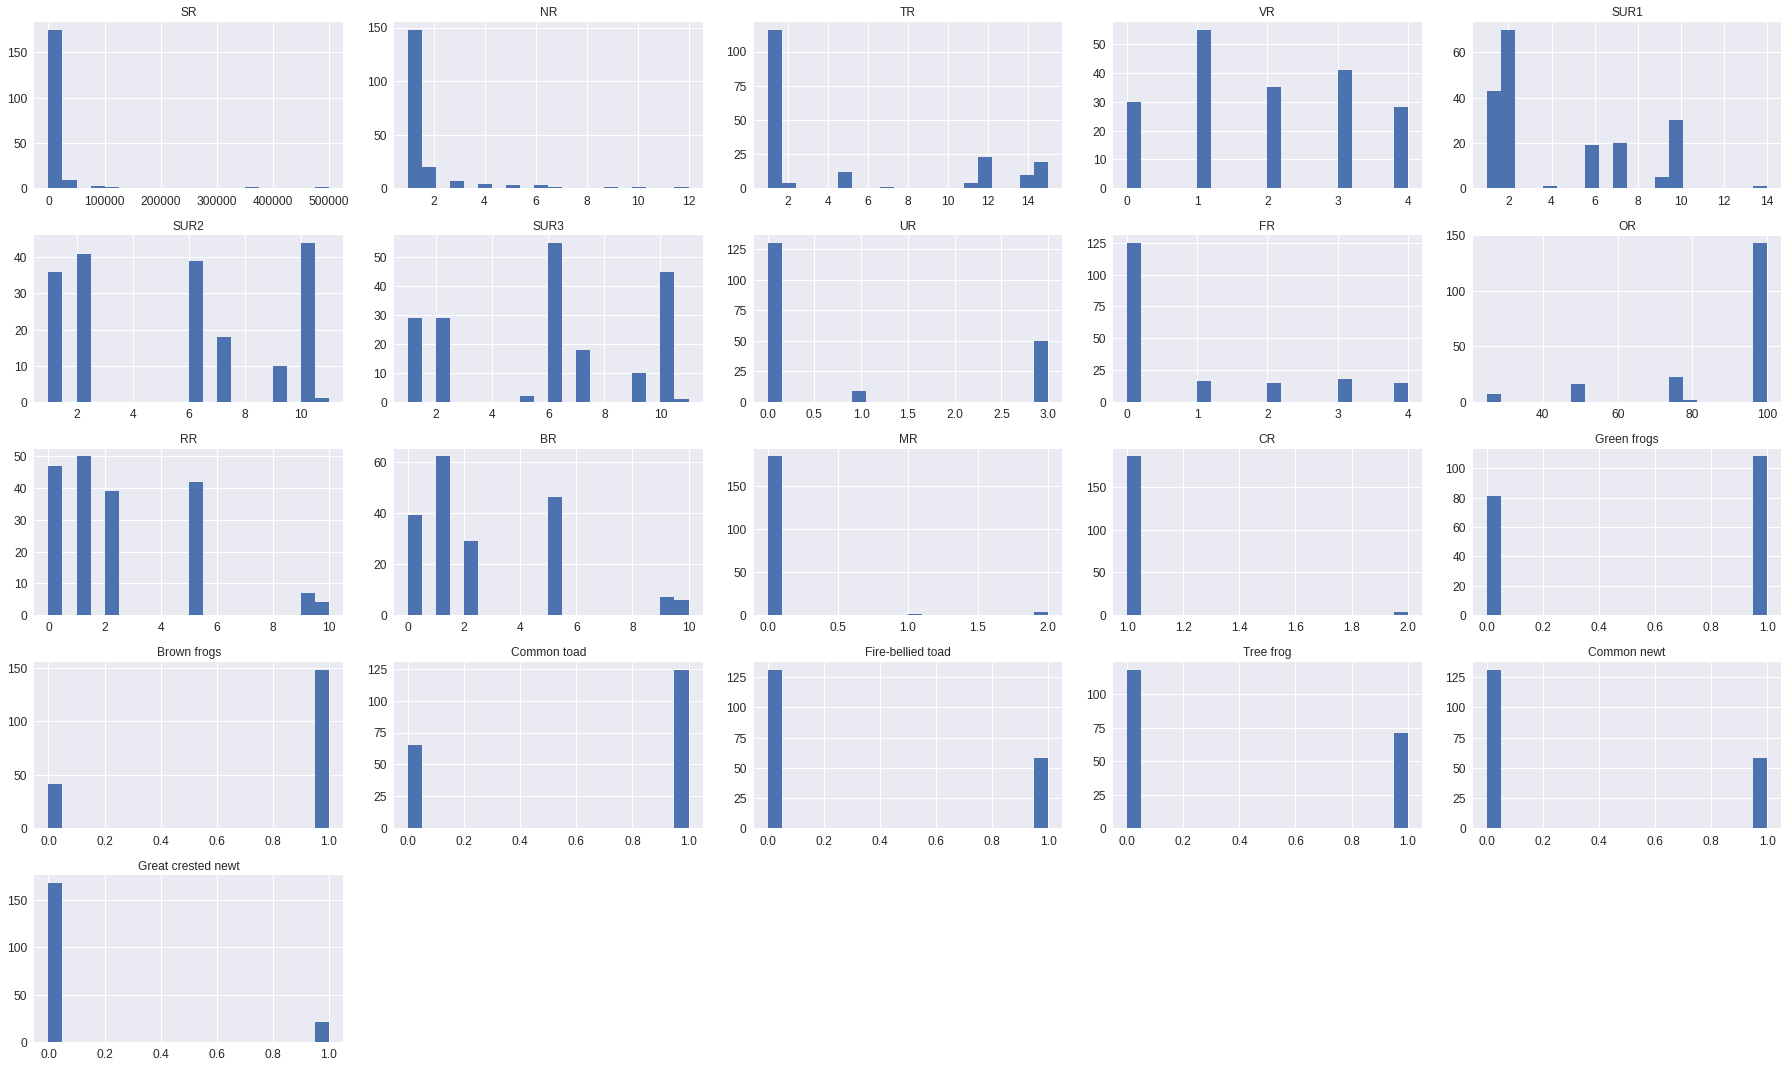

In [11]:
# Print data histogram
amphibians.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_histogram.pdf', dpi=600)

Based on histogram exploration it is apparent that the data distribution is imbalanced and contains outliers across the several features. Most notably *SR* and *NR* are affected by outliering values.

Significant imbalance is visible at *MR* and *CR* features. Features like *UR*, *FR* and *OR* are also imbalanced but in smaller extend that previously mentioned categories. Significant imbalance is visible in target labels of *Brown frogs* and *Great crested newt*.

#### 2.4 Correlation pairs visualization and pairs sorting <a name="corr-visu"></a>

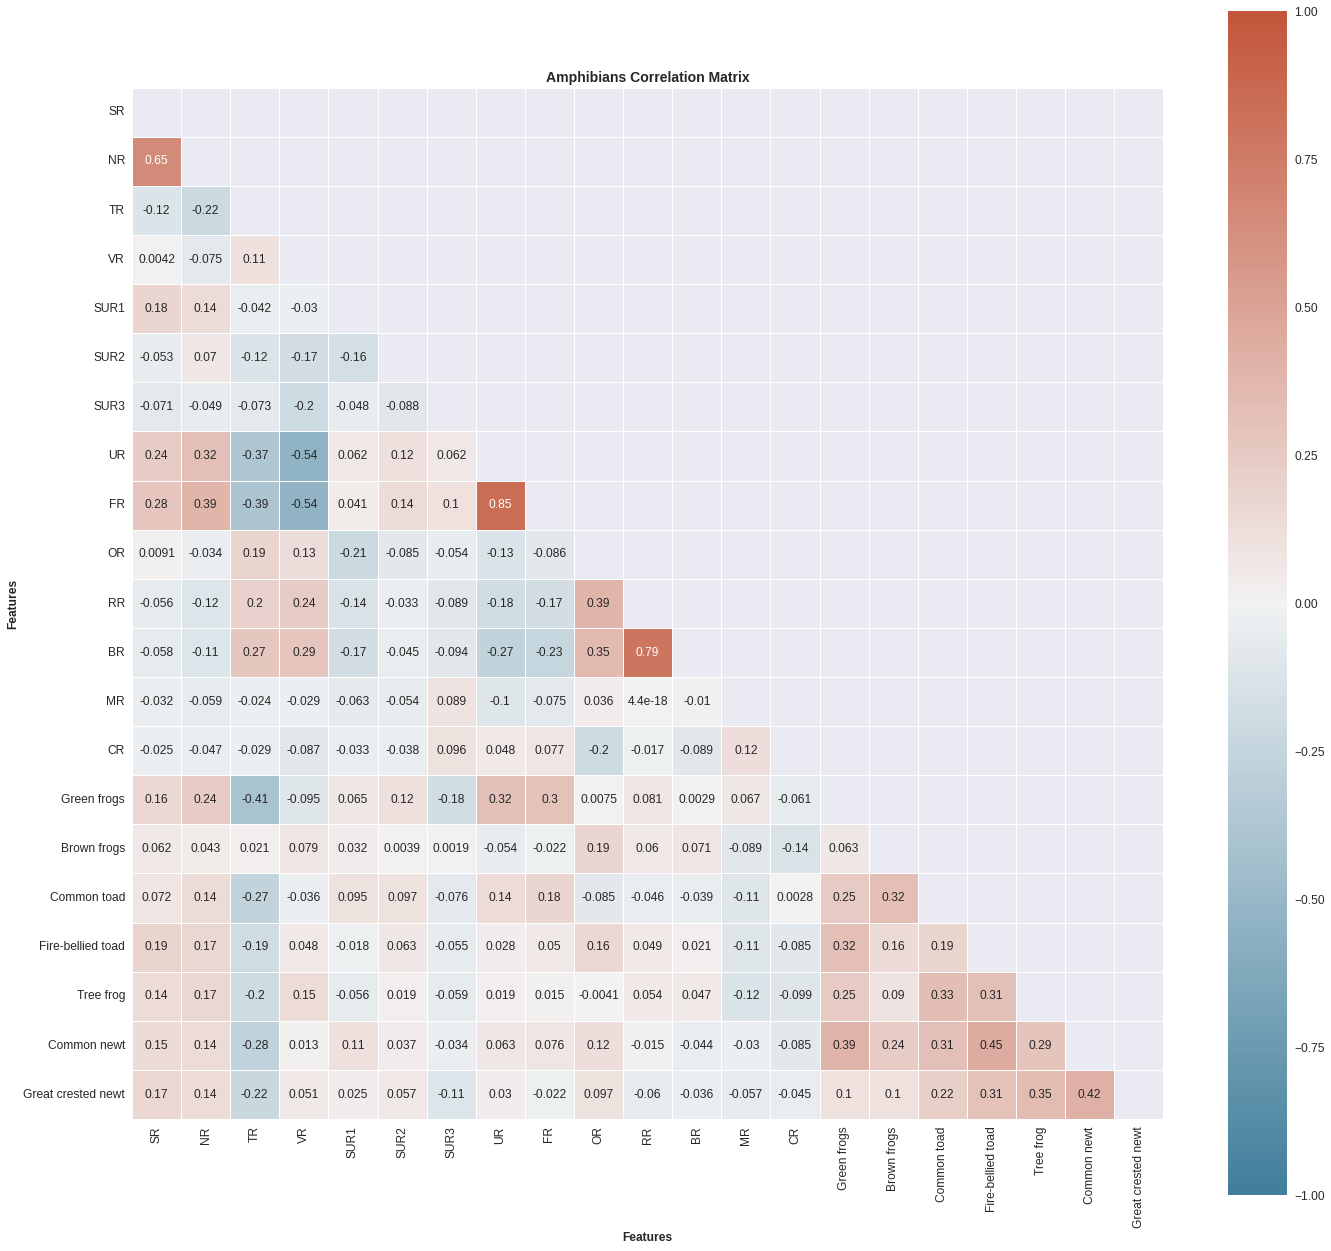

In [12]:
# Print correlation matrix
corr = print_corr_matrix(amphibians)

In [13]:
# Pairs sorting
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
sorted_pairs.drop_duplicates(inplace=True)

print('----- Strong Positive Pairs -----')
strong_positive_pairs = sorted_pairs[sorted_pairs > 0.5]
strong_positive_pairs.drop_duplicates(inplace=True)
print(strong_positive_pairs,'\n')

print('----- Strong Negative Pairs -----')
strong_negative_pairs = sorted_pairs[sorted_pairs < -0.5]
strong_negative_pairs.drop_duplicates(inplace=True)
print(strong_negative_pairs,'\n')

----- Strong Positive Pairs -----
SR  NR    0.652757
RR  BR    0.792273
UR  FR    0.846052
SR  SR    1.000000
dtype: float64 

----- Strong Negative Pairs -----
UR  VR   -0.542904
FR  VR   -0.537696
dtype: float64 



By observation of visualized correlation matrix it's clear, that there is the vast majority of weakly correlating features. Strong positive correlation was found only throughout the several pairs like *SR-NR*, *RR-BR*, *UR-FR* or negative at *UR-VR* or *FR-VR*.

Weakest correlating features were identified at *MR* and *CR* categories. Not surprisingly, these are the same with the most imbalanced data. These features were decided to remove from the dataset.

In [14]:
# Drop MR and CR columns
amphibians.drop(columns=['MR', 'CR'], inplace=True)

### 3. Outliers handling <a name="outliers"></a>

As was already pointed out in 2.3, *SR* and *NR* features suffers the most by outliering values.

Before using any technique for outliers identification and removal, it's necessary to keep in mind that any row removal in this particular dataset is undesirable due to small amount of data points.

To have absolute control of how many rows going to be removed, it was decided to set limits for values to be searched in each category. Based on histogram observation and with precondition to remove as litte amount of rows as possible, limits to drop larger values were set to 11000 for *SR* and 4 for *NR*. This resulted in total removal of 23 rows.

In [15]:
# Outliers removal
SR_lim = 11000
NR_lim = 4
amphibians_rem_out = remove_outliers(amphibians, SR_lim, NR_lim)

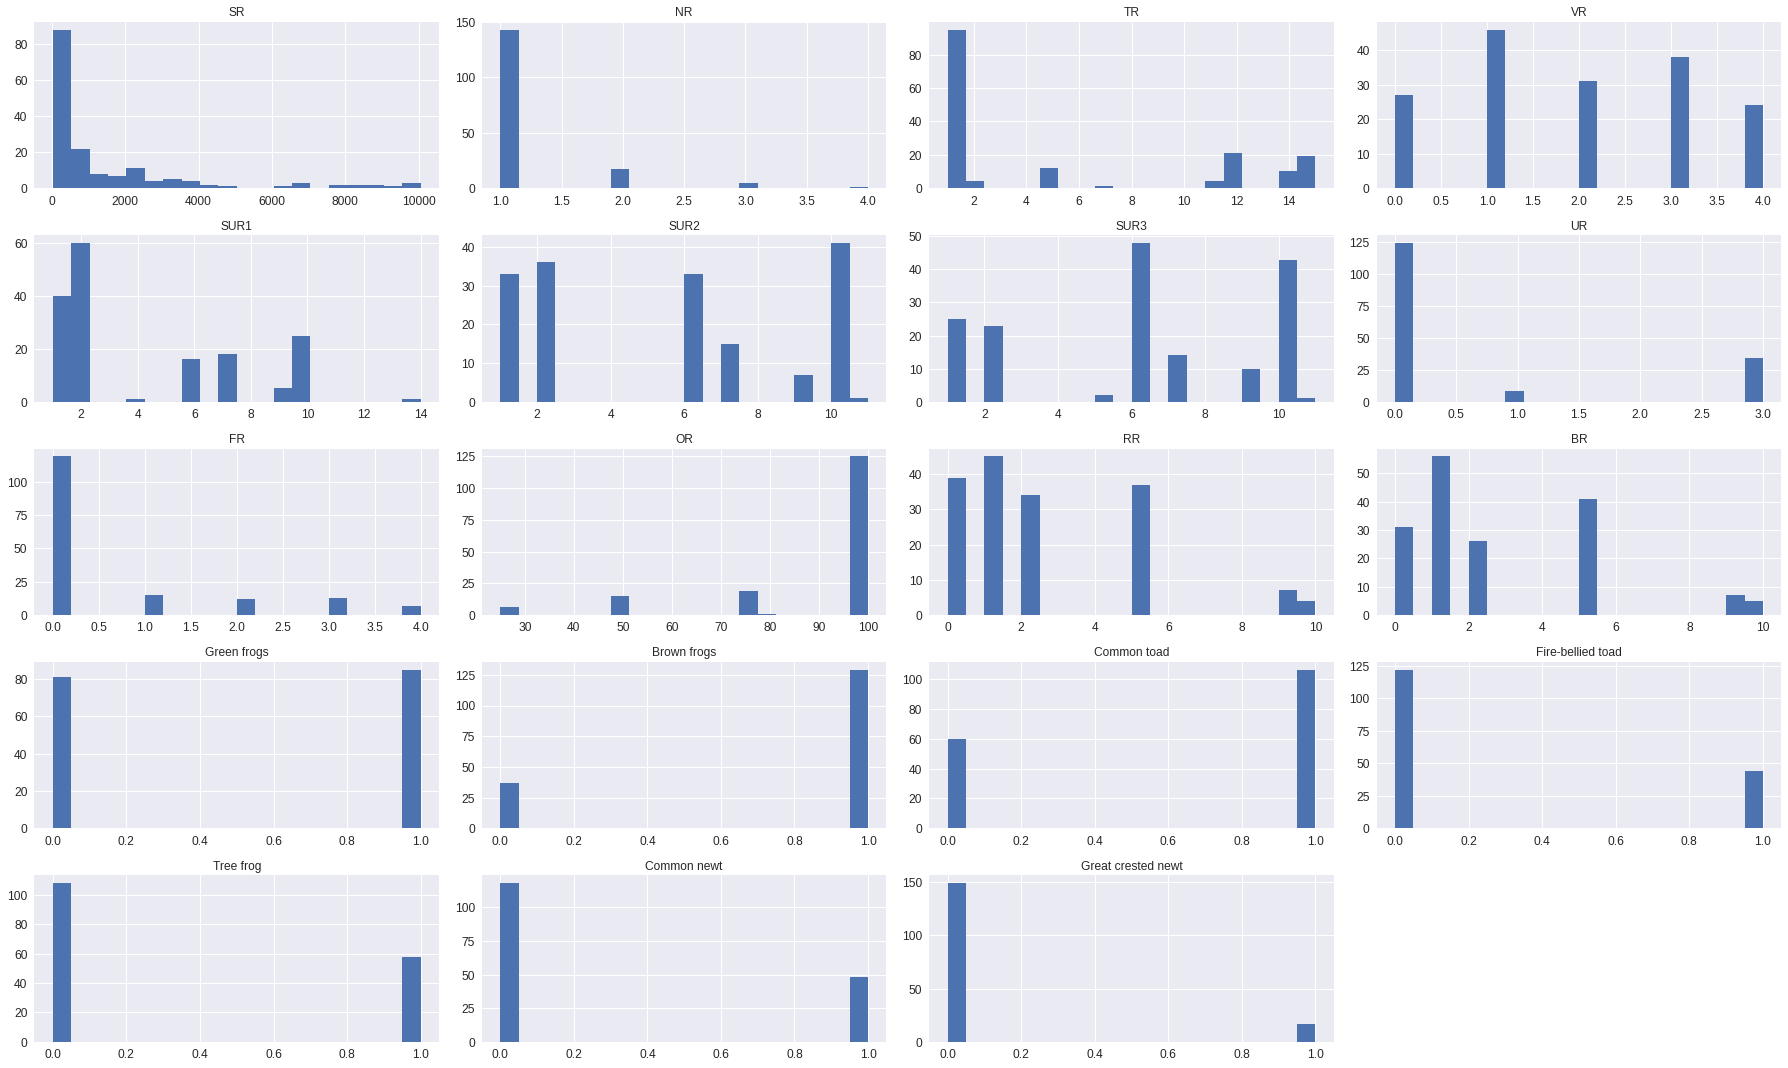

In [16]:
# Print histogram without outliers
amphibians_rem_out.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_rem_out_histogram.pdf', dpi=600)

### 4. Imbalance dataset handling <a name="imbalance-handling"></a>

There are various techniques available of how to handle imbalance in datasets features. In case of this data, there is however several limiting factors which at the end drastically reduces options of how to balance data.

The first factor is the small dataset. This force to focus mainly to usage of oversampling techniques. Most of them can be applied to single labelled targets without any issues. In this study, intention is to predict multiple labels on small amount of data and that's what causes the challenge. Spectrum of tools for balancing multi labelled targets by oversampling is not wide and is still matter of the latest research.

Oversampling techniques used in this study is proposed by *Bin Liuand* and *Grigorios Tsoumaka* and was published in paper [Synthetic Oversampling of Multi-Label Data based on Local Label Distribution](#https://arxiv.org/pdf/1905.00609.pdf).  It's a newly proposed method for synthetic oversampling of multi-label data that focuses on local label distribution to generate more diverse and better labeled instances.

For further implementation of the approach above, dataset features were separated into numerical and categorical in order to perform labels encoding before application of the multilabel oversampling.

In [17]:
# Separate independent and dependent features and targets
target_columns = ['Green frogs', 'Brown frogs', 'Common toad', 'Fire-bellied toad', 'Tree frog', 'Common newt', 'Great crested newt']

X = amphibians_rem_out.drop(columns=target_columns)  # All features
X_num = amphibians_rem_out[['SR', 'NR', 'OR']]  # Numerical features
X_cat = X.drop(columns=['SR', 'NR', 'OR'])  # Categorical features
y = amphibians_rem_out[target_columns]  # Targets

#### 4.1 Categorical labels encoding <a name="encoding"></a>

In [18]:
# Encode categorical labels
X_cat_enc = encode_labels(X_cat)

# Merge dataframes
X_enc = pd.concat([X_num, X_cat_enc], axis=1, ignore_index=False)

#### 4.2 Multi-label oversampling <a name="oversampling"></a>

MLSol method for data ovesampling requires to pass oversample *ratio* and *neighbor* parameters. In order to find values optimal values, it was implemented bruteforce searching over combinations defined in the `ratios` and `neighbors` variables below.

In [19]:
# Run multilabel oversampling
ratios = np.arange(0.1,2,0.1)
neighbors = np.arange(2,10, 1)

X_s, y_s = run_ml_sampling(X_enc, y, ratios, neighbors)

In [20]:
# Finalize datasets
X_s.columns = X.columns
y_s.columns = y.columns

In [21]:
# Round categorical values and merge datasets
X_s_round = X_s[X_cat.columns].round()
X_s_round = pd.concat([X_s[X_num.columns], X_s_round], axis=1, ignore_index=False)

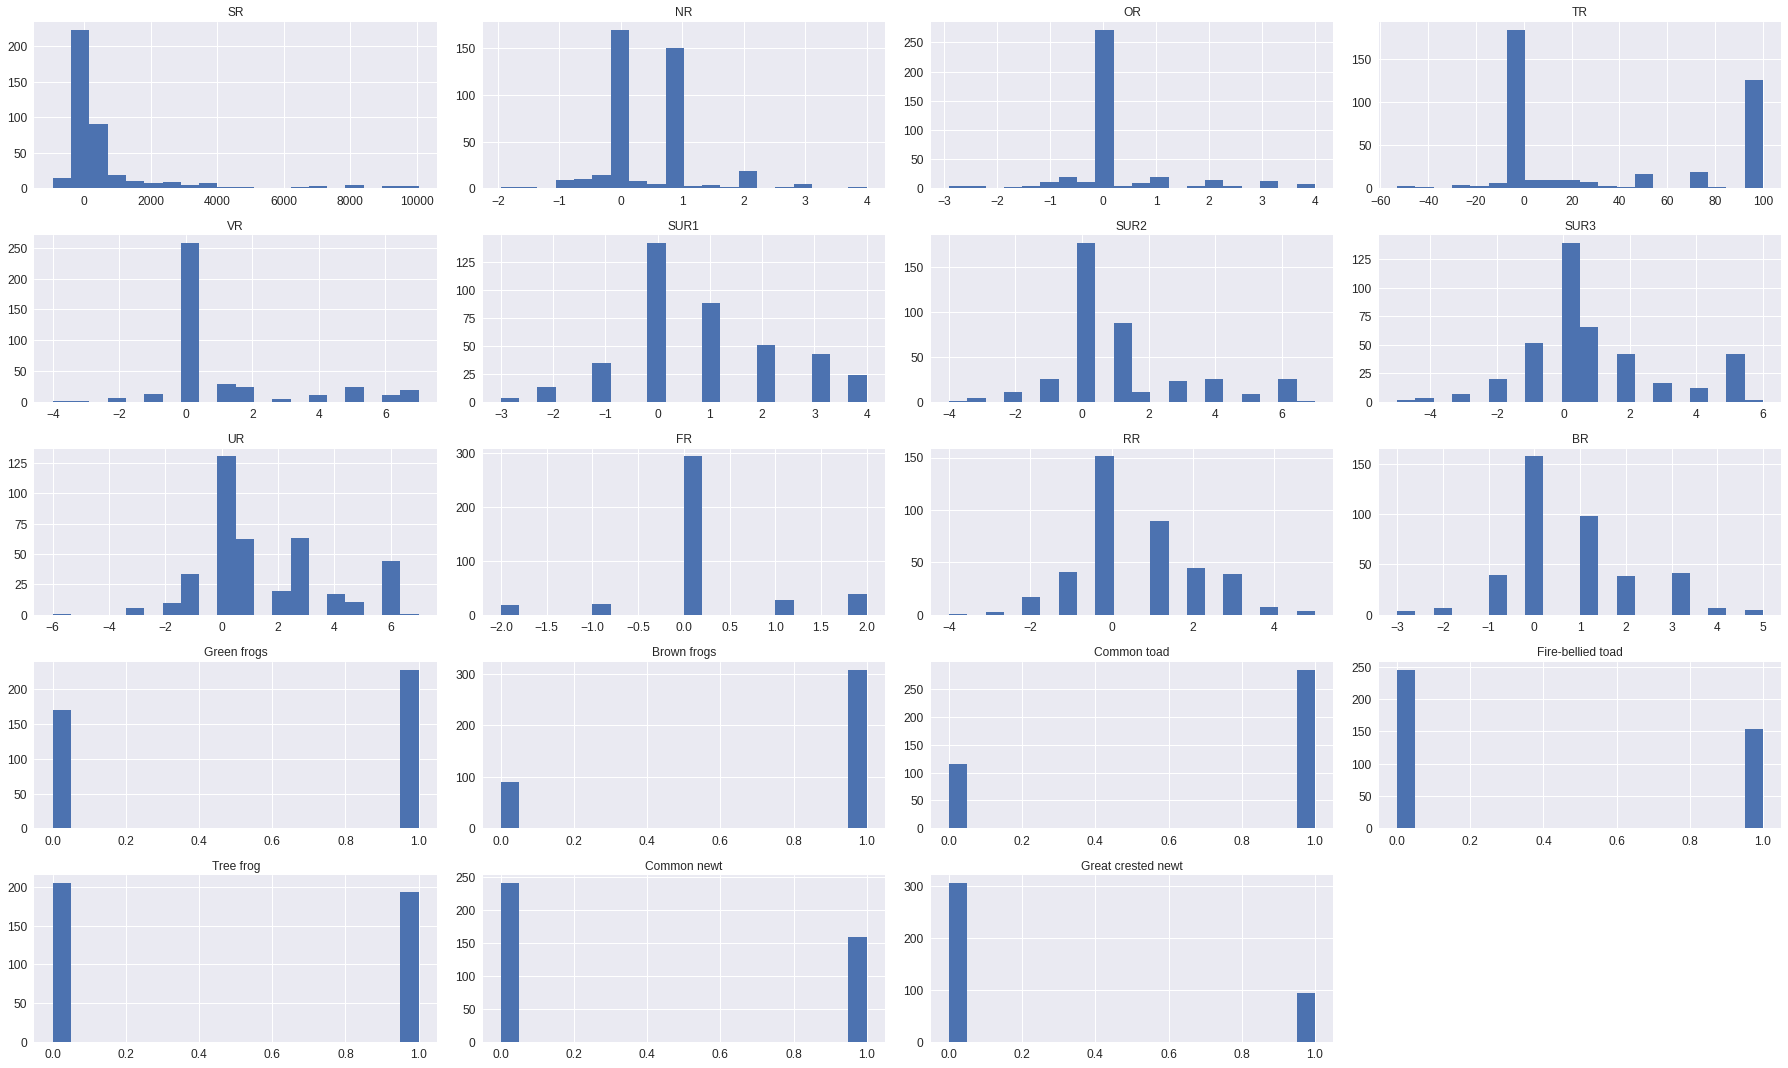

In [22]:
# Plot oversampled dataset
amphibians_oversample = pd.concat([X_s_round, y_s], axis=1, ignore_index=False)

amphibians_oversample.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_oversampled_histogram.pdf', dpi=600)

After observation of data distribution of oversampled dataset it is possible to see increased amount of the datapoints and change of the data distribution in the majority of features and targets.

In [23]:
# Save the dataset
amphibians_oversample.to_pickle('data/amphibians_oversample.pickle')

### 5. Models training <a name="models-training"></a>

For the purpose of comparison of the several models and with awareness of dataset size in mind, it was decided to use Scikit-learn library to build training and evaluation pipelines of machine learning models. To build classifiers based on neural nets would be quite overkill for this dataset.

ML pipelines incorporates data scaling, randomized search over space of model hyperparameters with K-fold cross-validation. Due to several labels to predict, *MultiOutputClassifier* class is used. Randomized search is evaluated by *f1_samples, accuracy* and *roc_auc* scoring. There are used 4 models in total to perform classification:

* **Logistic Regression** -  known as Log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function. [ --> more details](#https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* **KNeighbors Classifier** - implements learning based on the  nearest neighbors of each query point, where  is an integer value specified by the user. [ --> more details](#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
* **Decision Tree Classifier** - non-parametric supervised learning method used to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. [ --> more details](#https://scikit-learn.org/stable/modules/tree.html#)
* **Random Forest Classifier** - averaging algorithms based on randomized decision trees. Diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers. [ --> more details](#https://scikit-learn.org/stable/modules/ensemble.html#forest)

Evaluation of the model performance is done by *ROC* curves plotted for each target for each trained model. Final model evaluation is based on mutually compared micro averaged *ROC* curves where metrics is calculated globally by considering each element of the label indicator matrix as a label.

#### 5.1 Training of the multiple models <a name="training"></a>

Script `models_training.py` is responsible for training and evaluation of all models and contains all relevant input parameters, hyperparameters space definition and scoring conditions including plotting *ROC* curves.

Training all models...


Training the Logistic model...



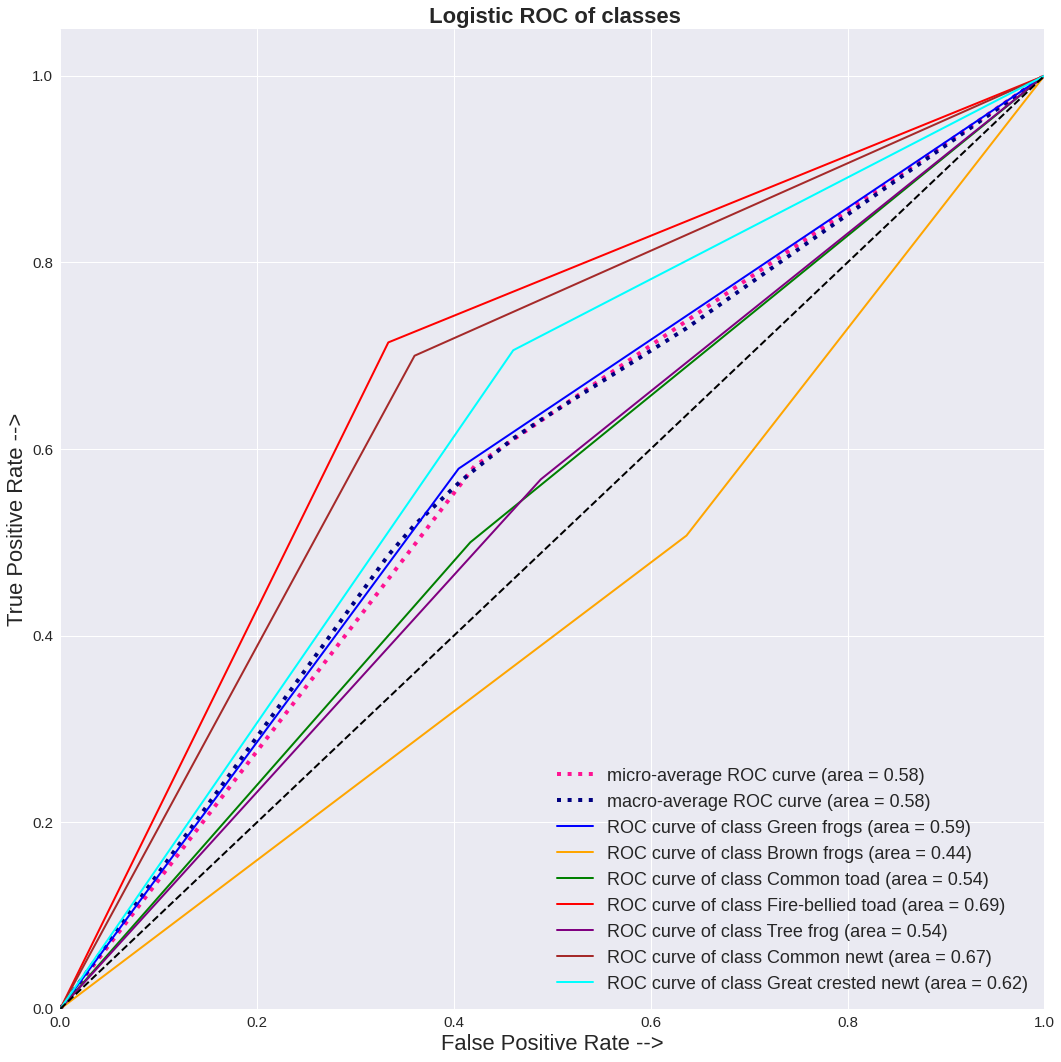


------ The best parameters of the Logistic model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.09915644566638389,
                                                                    class_weight='balanced',
                                                                    solver='liblinear')))])
--------------------------------------------------
The best cross-validation score: 0.5333812453529715
Accuracy: 0.0875
F1: 0.5825932504440496
ROC_AUC: 0.5838653061114892
--------------------------------------------------

Logistic model training finished in: 0:00:01

Training the KNeighbor model...



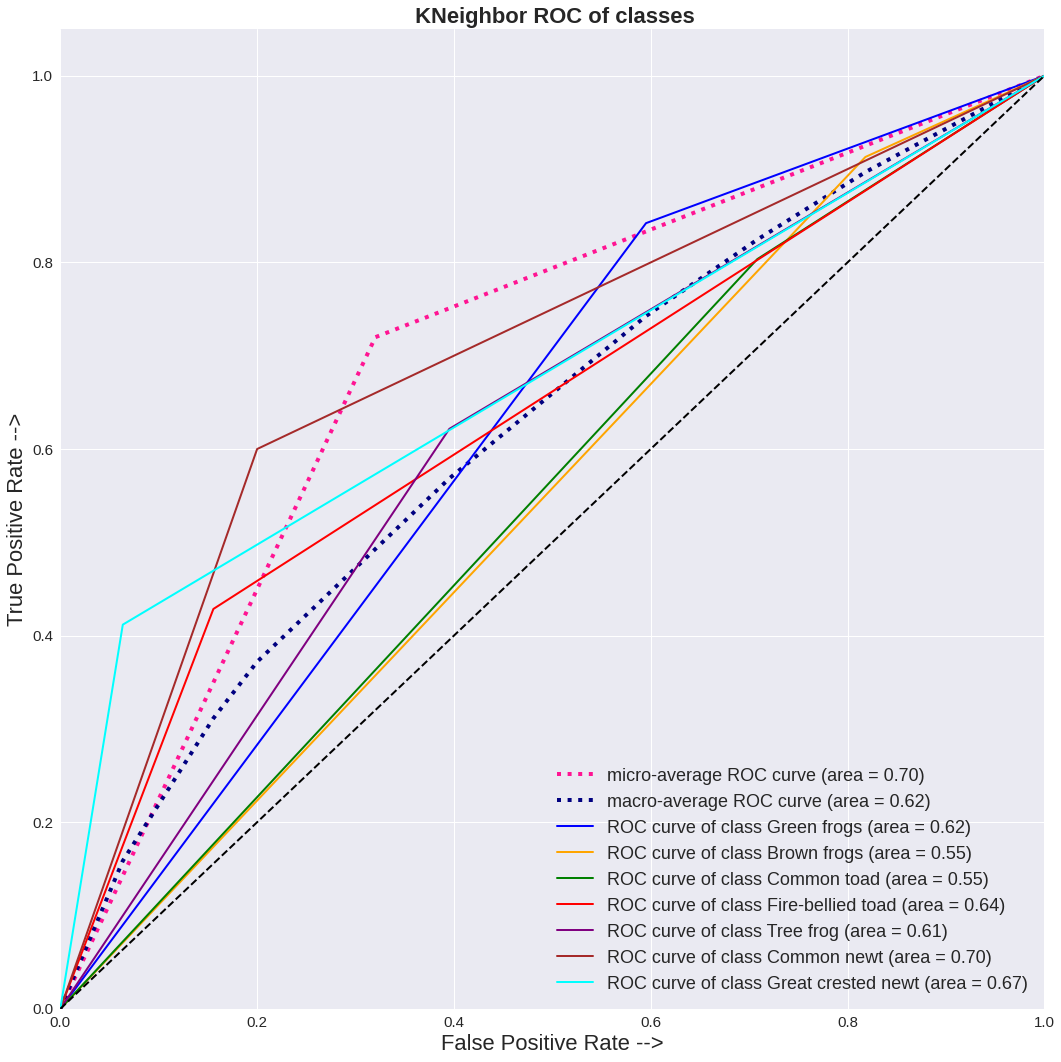


------ The best parameters of the KNeighbor model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='kd_tree',
                                                                      leaf_size=20,
                                                                      metric='euclidean',
                                                                      weights='distance')))])
--------------------------------------------------
The best cross-validation score: 0.6091172047198834
Accuracy: 0.175
F1: 0.7073170731707317
ROC_AUC: 0.620323444503959
--------------------------------------------------

KNeighbor model training finished in: 0:00:00

Training the Decision_Tree model...



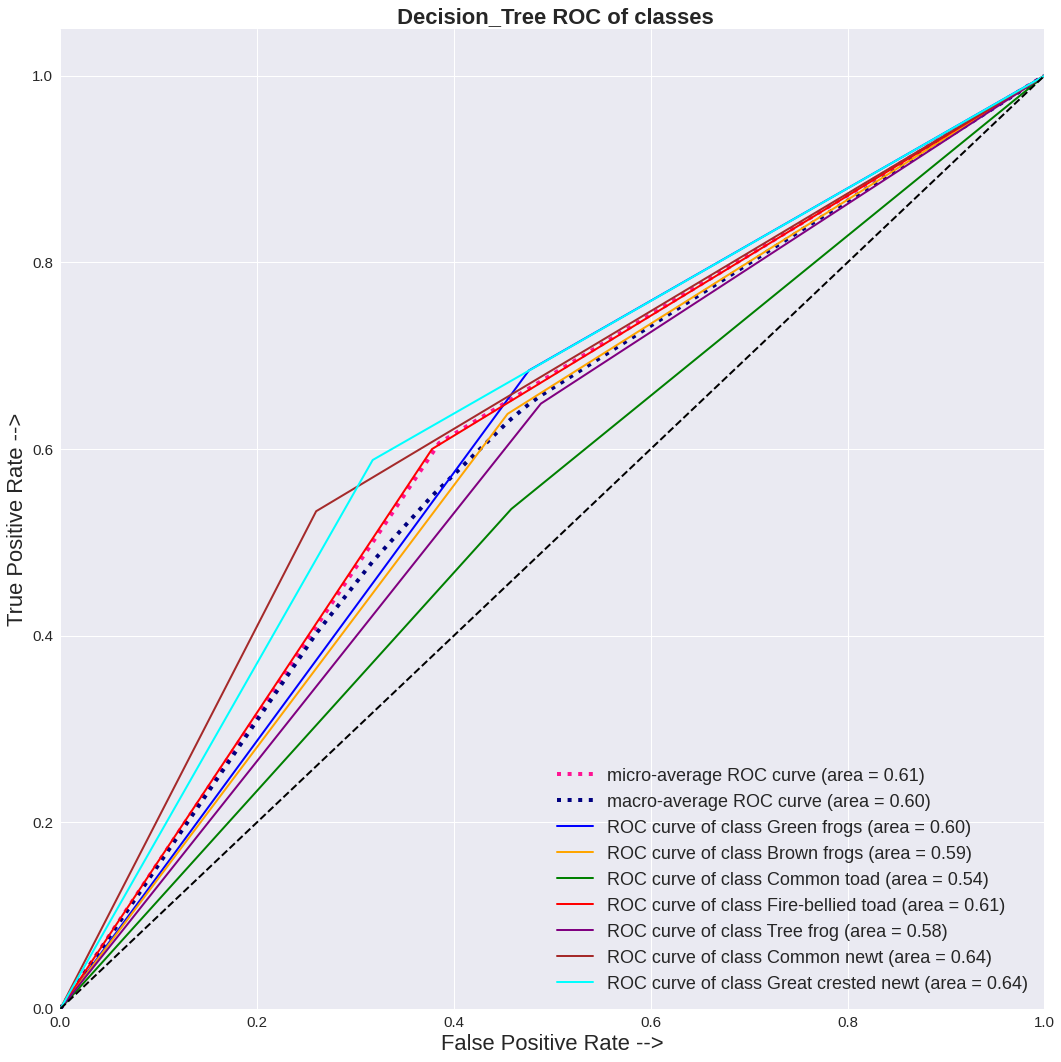


------ The best parameters of the Decision_Tree model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=3,
                                                                        min_samples_split=4)))])
--------------------------------------------------
The best cross-validation score: 0.5242096037780561
Accuracy: 0.0375
F1: 0.6107142857142858
ROC_AUC: 0.5996531282299556
--------------------------------------------------

Decision_Tree model training finished in: 0:00:00

Training the Random_Forest model...



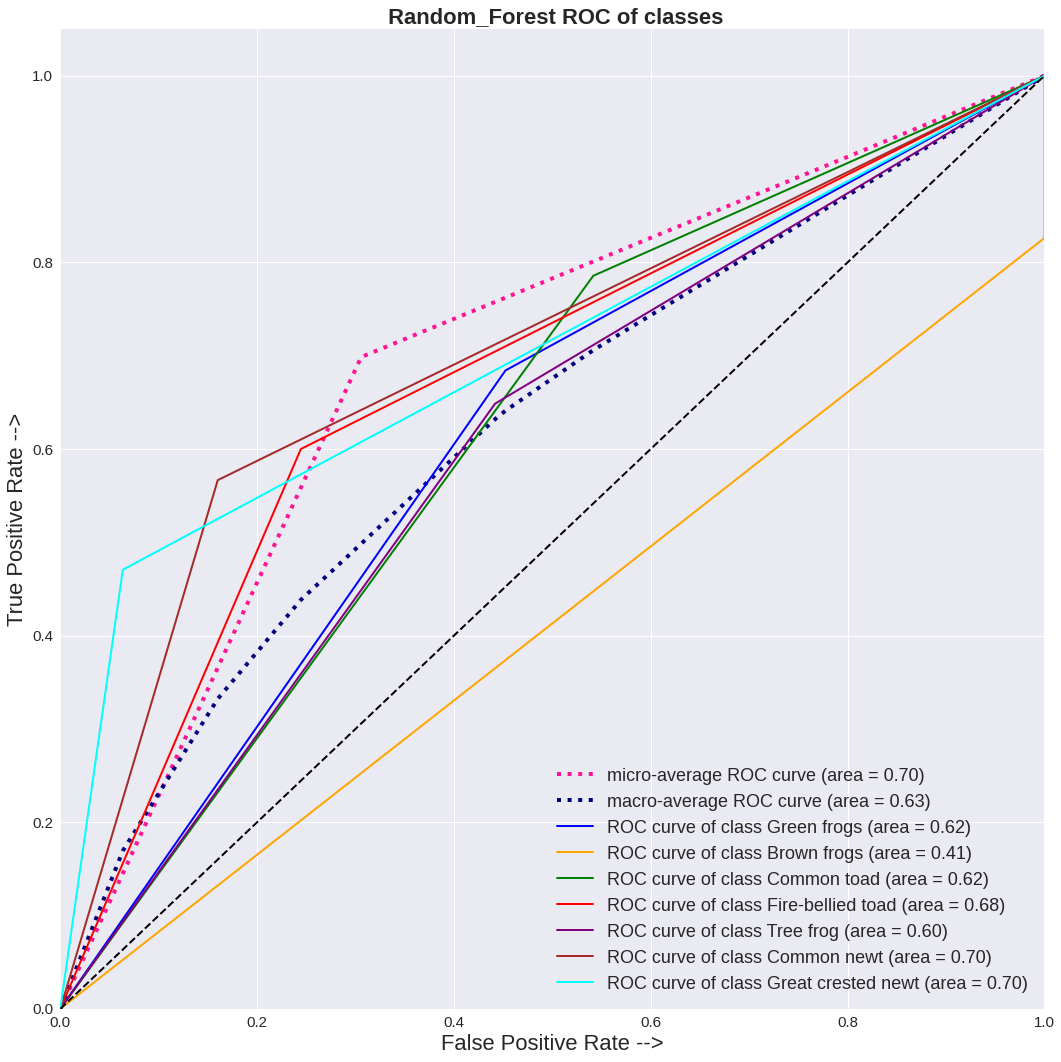


------ The best parameters of the Random_Forest model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                        criterion='entropy',
                                                                        max_depth=80,
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=4,
                                                                        n_estimators=800)))])
--------------------------------------------------
The best cross-validation score: 0.6318879172525006
Accuracy: 0.175
F1: 0.6985815602836879
ROC_AUC: 0.6198621947900601
--------------------------------------------------

Random_Forest model training finished in: 0:00:19


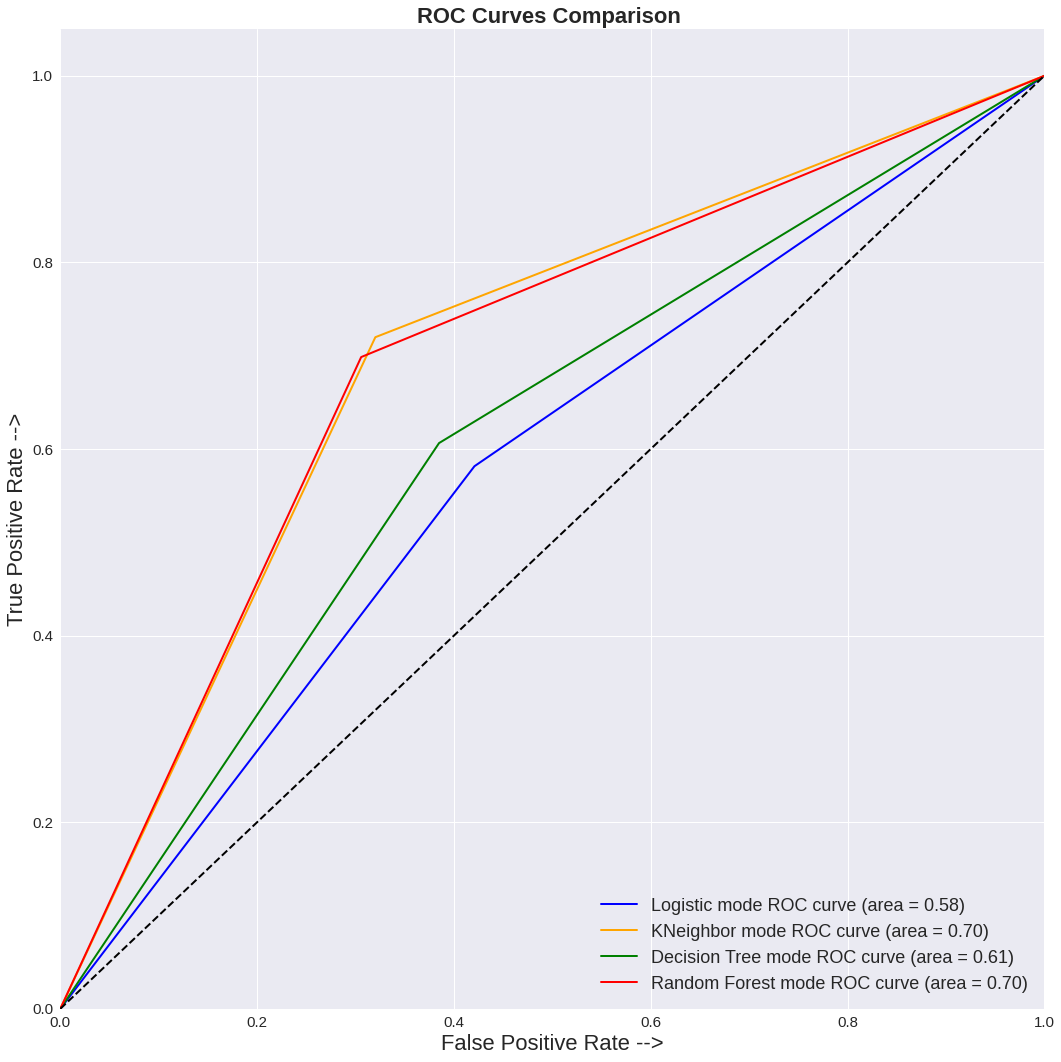


All models trained in: 0:00:22


<Figure size 576x396 with 0 Axes>

In [24]:
# Load and extract data from raw CSVs into dataframes for S&P500 and relevant events
%run lib/models_training.py

#### 5.2 Dataset with predicted values finalization <a name="finalization"></a>

As a last step is performed merge of testing dataset with predicted targets for each particular model. Finally, the whole dataframe is exported into `amphibians_eval_data.csv` file.

In [25]:
# Selecting the features
amphibians_eval = X_test[X_test.columns]

In [26]:
# Concatenate dataframes
amphibians_eval = concat_df(amphibians_eval, y_test, '')  # Concating the ground truth volume
amphibians_eval = concat_df(amphibians_eval, l_y_pred, '-Logistic Regression pred')  # Concatenating the Logistic Regression predictions
amphibians_eval = concat_df(amphibians_eval, kn_y_pred, '-KNeighbor pred')  # Concatenating the KNeighbor predictions
amphibians_eval = concat_df(amphibians_eval, dt_y_pred, '-Decision Tree pred')  # Concatenating the Decision Tree predictions
amphibians_eval = concat_df(amphibians_eval, rf_y_pred, '-Random Forest pred')  # Concatenating the Random Forest predictions

In [27]:
# Sorting according to index
amphibians_eval.sort_index(ascending=True, inplace=True)
amphibians_eval.reset_index(drop=True, inplace=True)

In [28]:
# Export to csv
amphibians_eval.to_csv('export/amphibians_eval_data.csv', header=True)

### 6. Results discussion <a name="results-discussion"></a>

### 7. Conclusion <a name="conclusion"></a>

There has been performed exploratory data analysis with trained and mutually compared models for a classification task on the Amphibians dataset.

Initial dataset exploration covered investigation of the data distribution, missing data and correlation pairs. Next, there were identified and removed outliers. Another step was improvement of the data imbalances by incorporating categorical labels encoding and algorithm for multi-label oversampling. Such a modified dataset was used as input for training and evaluation pipelines of linear, tree based, nearest neighbors and ensemble models. Performance of the models was mutually compared. Lastly, all predictions are finalized in dataset end exported.

Although there are differences between model performance, in general all of them perform poorly. The main reason can be seen in very small amount of data which were obtained for the dataset. To have at least several thousands of data points would have positive impact on the whole workflow of how analysis was handled. It would be possible to use resampling techniques instead oversampling for multi-labeled data to improve data balance more significantly. It would also allow more intense training of the models and investigate more in depth difference between their performance.

There is still lot of space for hyperparemetes tuning and model scoring part. For example it can be considered searching for optimal parameters with successive halving.

To improve models performance, I would see the potential for the future work according to following priorities:
1. Acquire more data
2. Improve targets balance even more
3. Training pipelines tuning
4. Possible feature engineering


